# Overview of the Baseline Models
## Fitted using all baseline data since 2008

Prerequisites:

- numpy
- pandas
- scipy
- matplotlib
- sklearn>=1.0.2
- sktime==0.10.0
- xgboost>=1.5.0
- pygam>=0.8.0



In [1]:
# import statements
import numpy as np
import pandas as pd
import joblib
import sys
import os
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,:4]).astype(int)
    return X, Y

dataset = pd.read_pickle('../Dataset/baseline_dataset_tsnv_2008_24.gz')
# train-dev-test splitting
splitDataset = separateDataset(dataset, 0.9)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 5634; Dev set size: 627; Testing set size: 696


## Helper functions

In [3]:
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.metrics import precision_recall_curve, classification_report, f1_score, precision_score, recall_score, accuracy_score

In [4]:
def optimize_thresholds(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    # find the best decision thresholds and the corresponding F1 scores
    all_preds = np.array(clf.predict_proba(dataset_X))
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        if isinstance(clf, MultiOutputClassifier):
            precision, recall, thresholds = precision_recall_curve(dataset_Y[:,i], all_preds[i,:,1])
        else:
            precision, recall, thresholds = precision_recall_curve(dataset_Y[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the last class/label
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def predictions_with_thresholds(clf, thresholds, dataset_X):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = np.array(clf.predict_proba(dataset_X))
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    if isinstance(clf, MultiOutputClassifier):
        for i in range(preds_probs.shape[1]):
                pred_row = []
                for j in range(n_classes):
                    if preds_probs[j,i,1] > thresholds[j]:
                        pred_row.append(1)
                    else:
                        pred_row.append(0)
                preds.append(pred_row)
    else:
        for i in range(preds_probs.shape[0]):
            pred_row = []
            for j in range(n_classes):
                if preds_probs[i,j] > thresholds[j]:
                    pred_row.append(1)
                else:
                    pred_row.append(0)
            preds.append(pred_row)        
    
    return np.array(preds)

In [5]:
from scipy.special import expit

def regression_predict(regr, datasetX, method='clip'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='clip', probs_given=False, probs=None):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    optionally accepts a given matrix of predicted probabilities (probs_given=True, probs=...);
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    if probs_given:
        all_preds = probs
    else:
        all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='clip', probs_given=False, probs=None):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    optionally accepts a given matrix of predicted probabilities (probs_given=True, probs=...);
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    if probs_given:
        preds_probs = probs
    else:
        preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [6]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

def calibration_plot(clf, dataset_X, dataset_Y, probs_given=False, probs=None):
    '''
    Takes in a classifier, an input set X and a target set Y;
    optionally accepts a given matrix of predicted probabilities (probs_given=True, probs=...);
    Calculates and shows Brier scores and plots calibration graphs for reference.
    '''
    # brier score loss
    print("Brier score losses: (the smaller the better)")  
    if probs_given:
        all_preds = probs
    elif isinstance(clf, MultiOutputRegressor):
        all_preds = regression_predict(clf, dataset_X)
    else:
        all_preds = np.array(clf.predict_proba(dataset_X))
    for i in range(4):
        if isinstance(clf, MultiOutputClassifier):
            preds = all_preds[i,:,1]
        else:            
            preds = all_preds[:,i]
        clf_score = brier_score_loss(dataset_Y[:,i], preds)
        print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

    # plot calibration graphs
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    ax = fig.add_subplot(gs[:2, :2])

    if probs_given:
        all_preds = probs
    elif isinstance(clf, MultiOutputRegressor):
        all_preds = regression_predict(clf, dataset_X)
    else:
        all_preds = np.array(clf.predict_proba(dataset_X))
    preds = all_preds[0,:,1] if isinstance(clf, MultiOutputClassifier) else all_preds[:,0]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
    preds = all_preds[3,:,1] if isinstance(clf, MultiOutputClassifier) else all_preds[:,3]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

    ax.grid()
    plt.tight_layout()
    plt.show()

## Group 1: Trees

This group has a couple variants, depending on whether probability calibration was performed. The models to show include

- multi-output XGBoost classifier
- multi-output XGBoost classifier (grid search optimized)
- multi-output XGBoost classifier (calibrated)
- multi-output XGBoost classifier (grid search optimized, calibrated)
- multi-output extra trees classifier (default settings) 
- multi-output extra trees classifier (grid search optimized settings)  
- multi-output XGBoost regressor (grid search optimized)  
- multi-output extra trees regressor (grid search optimized settings)

The first one was tried on the old dataset with average f1 0.81360, and the new model gives 0.87635. The best now is 0.90432 by optimized xgb regressor.

---
##### multi-output XGBoost classifier

In [4]:
# imports
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier

xgb_clf = joblib.load("./models/baseline_model_downsampled_xgb_clf_2022-04-06 18-47.skl")
xgb_thresholds = [0.14693, 0.59976, 0.39765, 0.32841]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.014693
Class 1, no calibration: 0.013851
Class 2, no calibration: 0.006981
Class 3, no calibration: 0.005498


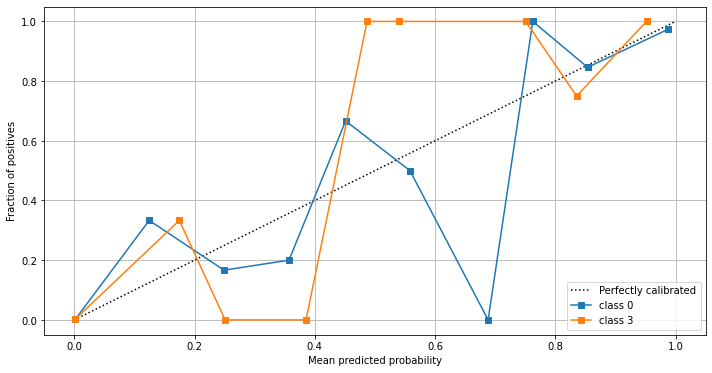

In [8]:
calibration_plot(xgb_clf, test_X, test_Y)

In [9]:
preds = predictions_with_thresholds(xgb_clf, xgb_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.82569   0.97826   0.89552        92
           1    0.96610   0.85075   0.90476        67
           2    0.84211   0.80000   0.82051        20
           3    0.86667   0.86667   0.86667        15

   micro avg    0.87129   0.90722   0.88889       194
   macro avg    0.87514   0.87392   0.87187       194
weighted avg    0.87904   0.90722   0.88875       194
 samples avg    0.13326   0.13015   0.12930       194



##### multi-output XGBoost classifier (grid search optimized)

In [10]:
xgb_gscv_clf = joblib.load("./models/baseline_model_downsampled_gscv_xgb_clf_2022-04-06 18-47.skl")
xgb_gscv_thresholds = [0.09820, 0.51843, 0.23937, 0.24413]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.015616
Class 1, no calibration: 0.012038
Class 2, no calibration: 0.008942
Class 3, no calibration: 0.003767


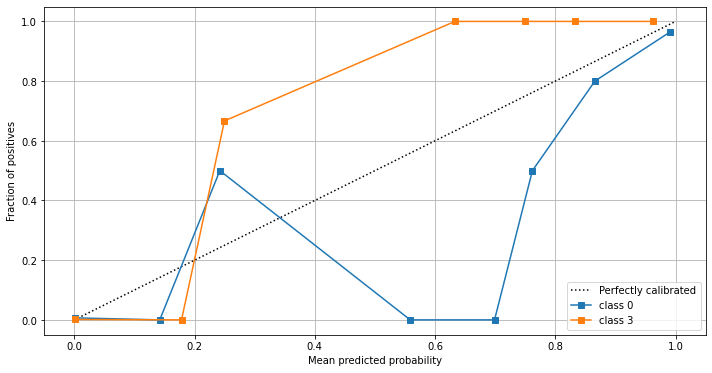

In [11]:
calibration_plot(xgb_gscv_clf, test_X, test_Y)

In [12]:
preds = predictions_with_thresholds(xgb_gscv_clf, xgb_gscv_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.87129   0.95652   0.91192        92
           1    0.95082   0.86567   0.90625        67
           2    0.73913   0.85000   0.79070        20
           3    0.92857   0.86667   0.89655        15

   micro avg    0.88442   0.90722   0.89567       194
   macro avg    0.87245   0.88472   0.87635       194
weighted avg    0.88956   0.90722   0.89628       194
 samples avg    0.12955   0.12847   0.12661       194



##### multi-output XGBoost classifier (calibrated)

In [13]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier

xgb_calibrated_clf = joblib.load("./models/baseline_model_downsampled_calibrated_xgb_clf_2022-04-06 18-49.skl")
xgb_calibrated_thresholds = [0.02889, 0.71758, 0.43159, 0.41829]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.016170
Class 1, no calibration: 0.016395
Class 2, no calibration: 0.008496
Class 3, no calibration: 0.004942


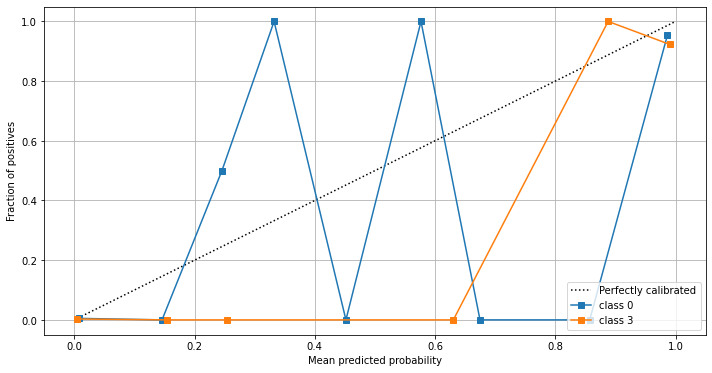

In [14]:
calibration_plot(xgb_calibrated_clf, test_X, test_Y)

In [15]:
preds = predictions_with_thresholds(xgb_calibrated_clf, xgb_calibrated_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.82569   0.97826   0.89552        92
           1    0.96610   0.85075   0.90476        67
           2    0.84211   0.80000   0.82051        20
           3    0.86667   0.86667   0.86667        15

   micro avg    0.87129   0.90722   0.88889       194
   macro avg    0.87514   0.87392   0.87187       194
weighted avg    0.87904   0.90722   0.88875       194
 samples avg    0.13326   0.13015   0.12930       194



##### multi-output XGBoost classifier (grid search optimized, calibrated)

In [16]:
xgb_gscv_calibrated_clf = joblib.load("./models/baseline_model_downsampled_calibrated_gscv_xgb_clf_2022-04-06 18-50.skl")
xgb_gscv_calibrated_thresholds = [0.01810, 0.44690, 0.10591, 0.07744]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.017039
Class 1, no calibration: 0.013154
Class 2, no calibration: 0.010987
Class 3, no calibration: 0.003985


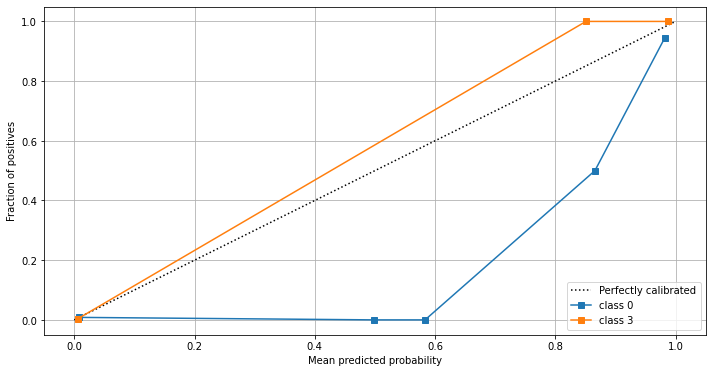

In [17]:
calibration_plot(xgb_gscv_calibrated_clf, test_X, test_Y)

In [18]:
preds = predictions_with_thresholds(xgb_gscv_calibrated_clf, xgb_gscv_calibrated_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.87129   0.95652   0.91192        92
           1    0.95082   0.86567   0.90625        67
           2    0.73913   0.85000   0.79070        20
           3    0.92857   0.86667   0.89655        15

   micro avg    0.88442   0.90722   0.89567       194
   macro avg    0.87245   0.88472   0.87635       194
weighted avg    0.88956   0.90722   0.89628       194
 samples avg    0.12955   0.12847   0.12661       194



##### multi-output XGBoost regressor (grid search optimized)

In [7]:
from sklearn.multioutput import MultiOutputRegressor

xgb_gscv_regr = joblib.load("./models/baseline_model_downsampled_gscv_xgb_regr_2022-04-16 15-01.skl")
xgb_gscv_thresholds = [0.41247, 0.40437, 0.46181, 0.24653]

Brier score losses: (the smaller the better)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

Class 0, no calibration: 0.015489
Class 1, no calibration: 0.014859
Class 2, no calibration: 0.008676
Class 3, no calibration: 0.005988


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

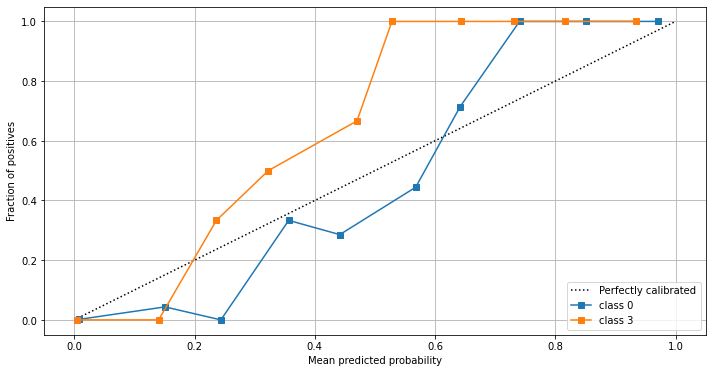

In [8]:
calibration_plot(xgb_gscv_regr, test_X, test_Y)

In [9]:
preds = regression_label(xgb_gscv_regr, test_X, xgb_gscv_thresholds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.88889   0.95652   0.92147        92
           1    0.89706   0.91045   0.90370        67
           2    1.00000   0.80000   0.88889        20
           3    0.87500   0.93333   0.90323        15

   micro avg    0.89950   0.92268   0.91094       194
   macro avg    0.91524   0.90008   0.90432       194
weighted avg    0.90209   0.92268   0.91056       194
 samples avg    0.13003   0.13087   0.12860       194



##### multi-output extra trees classifier (default settings)

In [19]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_clf = joblib.load("./models/baseline_model_downsampled_extra_trees_clf_2022-04-06 18-57.skl")
extra_trees_thresholds = [0.47000, 0.42000, 0.46000, 0.33000]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.015900
Class 1, no calibration: 0.016194
Class 2, no calibration: 0.011769
Class 3, no calibration: 0.007882


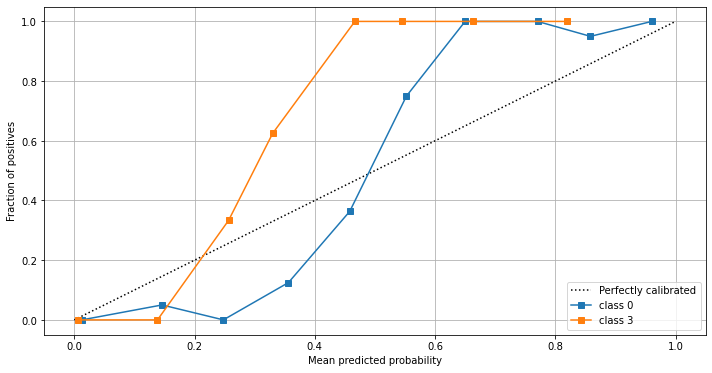

In [20]:
calibration_plot(extra_trees_clf, test_X, test_Y)

In [21]:
preds = predictions_with_thresholds(extra_trees_clf, extra_trees_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.93548   0.94565   0.94054        92
           1    0.93846   0.91045   0.92424        67
           2    1.00000   0.60000   0.75000        20
           3    1.00000   0.73333   0.84615        15

   micro avg    0.94475   0.88144   0.91200       194
   macro avg    0.96849   0.79736   0.86523       194
weighted avg    0.94815   0.88144   0.90797       194
 samples avg    0.12931   0.12668   0.12590       194



##### multi-output extra trees classifier (grid search optimized settings)

In [22]:
extra_trees_gscv_clf = joblib.load("./models/baseline_model_downsampled_gscv_extra_trees_clf_2022-04-06 18-56.skl")
extra_trees_gscv_thresholds = [0.31333, 0.40667, 0.52667, 0.34000]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.010723
Class 1, no calibration: 0.012499
Class 2, no calibration: 0.008748
Class 3, no calibration: 0.007862


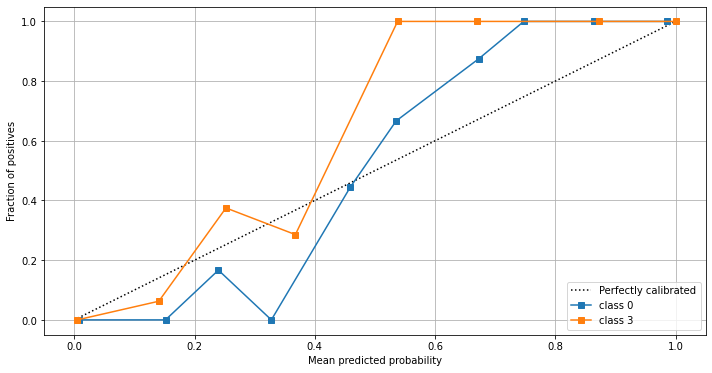

In [23]:
calibration_plot(extra_trees_gscv_clf, test_X, test_Y)

In [24]:
preds = predictions_with_thresholds(extra_trees_gscv_clf, extra_trees_gscv_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.89216   0.98913   0.93814        92
           1    1.00000   0.91045   0.95312        67
           2    1.00000   0.80000   0.88889        20
           3    0.78571   0.73333   0.75862        15

   micro avg    0.92746   0.92268   0.92506       194
   macro avg    0.91947   0.85823   0.88469       194
weighted avg    0.93229   0.92268   0.92436       194
 samples avg    0.13602   0.13350   0.13298       194



##### multi-output extra trees regressor (grid search optimized settings)

In [10]:
from sklearn.ensemble import ExtraTreesRegressor

extra_trees_gscv_regr = joblib.load("./models/baseline_model_downsampled_gscv_extra_trees_regr_2022-04-16 15-09.skl")
extra_trees_gscv_thresholds = [0.43018, 0.42667, 0.47333, 0.33333]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.011498
Class 1, no calibration: 0.012303
Class 2, no calibration: 0.009515
Class 3, no calibration: 0.007504


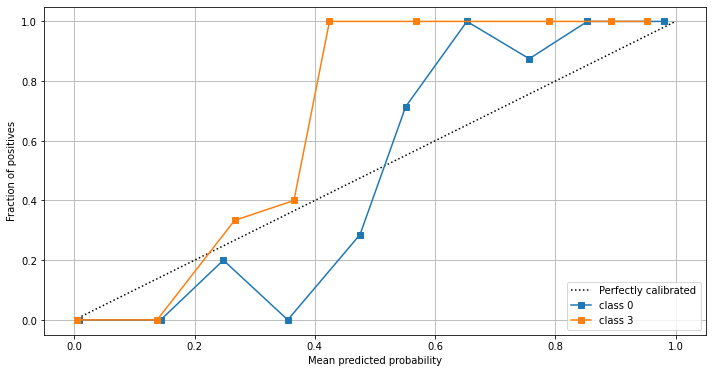

In [11]:
calibration_plot(extra_trees_gscv_regr, test_X, test_Y)

In [12]:
preds = regression_label(extra_trees_gscv_regr, test_X, extra_trees_gscv_thresholds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.91919   0.98913   0.95288        92
           1    1.00000   0.92537   0.96124        67
           2    0.94118   0.80000   0.86486        20
           3    0.84615   0.73333   0.78571        15

   micro avg    0.94241   0.92784   0.93506       194
   macro avg    0.92663   0.86196   0.89117       194
weighted avg    0.94372   0.92784   0.93377       194
 samples avg    0.13697   0.13410   0.13404       194



## Group 2: MLP

An MLP Classifier was fit. Below also shows why calibration won't work.

The old score was 0.76705, now 0.69481. MLPs may favour larger datasets.

In [7]:
from sklearn.neural_network import MLPClassifier

mlp_clf = joblib.load("./models/baseline_model_downsampled_mlpclf_2022-04-07 16-29.skl")
mlp_clf_thresholds = [0.64717, 0.56828, 0.60979, 0.85579]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.040058
Class 1, no calibration: 0.033040
Class 2, no calibration: 0.018066
Class 3, no calibration: 0.011381


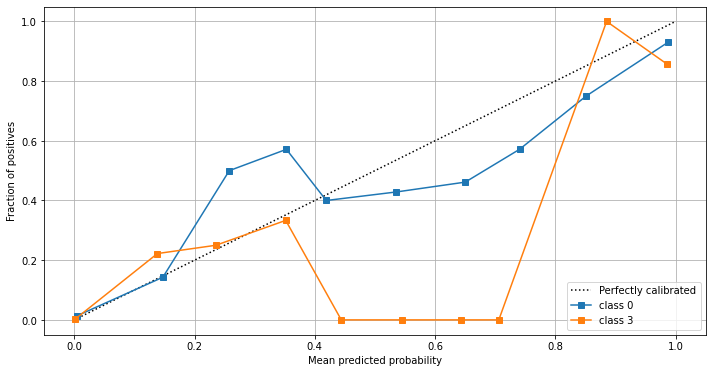

In [28]:
calibration_plot(mlp_clf, test_X, test_Y)

In [13]:
preds = predictions_with_thresholds(mlp_clf, mlp_clf_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.82500   0.71739   0.76744        92
           1    0.82759   0.71642   0.76800        67
           2    0.50000   0.55000   0.52381        20
           3    0.90000   0.60000   0.72000        15

   micro avg    0.78824   0.69072   0.73626       194
   macro avg    0.76315   0.64595   0.69481       194
weighted avg    0.79819   0.69072   0.73885       194
 samples avg    0.09219   0.09387   0.08955       194



Brier score losses: (the smaller the better)
Class 0, no calibration: 0.255338
Class 1, no calibration: 0.142751
Class 2, no calibration: 0.023424
Class 3, no calibration: 0.023327


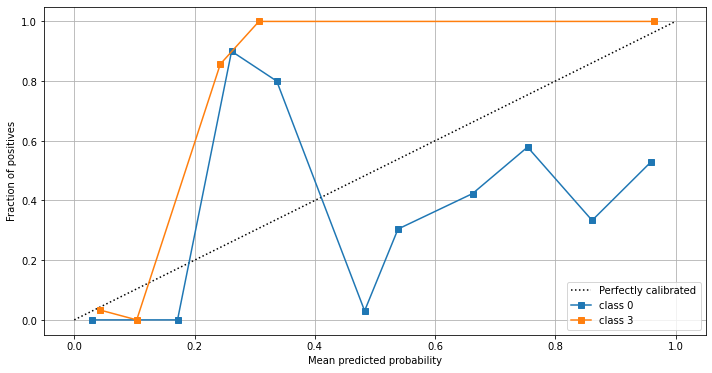

Best Threshold=0.49944, F-Score=0.44172
Best Threshold=0.37042, F-Score=0.64000
Best Threshold=0.09450, F-Score=0.88889
Best Threshold=0.23662, F-Score=0.90909
              precision    recall  f1-score   support

           0    0.40000   0.63043   0.48945        92
           1    0.87879   0.43284   0.58000        67
           2    0.51724   0.75000   0.61224        20
           3    0.88889   0.53333   0.66667        15

   micro avg    0.50926   0.56701   0.53659       194
   macro avg    0.67123   0.58665   0.58709       194
weighted avg    0.61524   0.56701   0.54708       194
 samples avg    0.12356   0.09171   0.10062       194



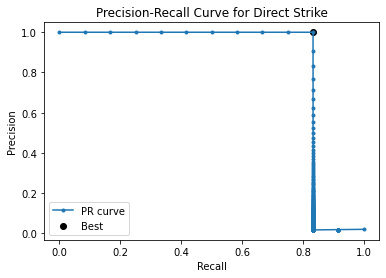

In [30]:
from sklearn.calibration import CalibratedClassifierCV

# calibrated estimator
calibrated_mlp_clf = CalibratedClassifierCV(base_estimator=mlp_clf, cv='prefit', n_jobs=-1, ensemble=False).fit(dev_X, dev_Y)

calibration_plot(calibrated_mlp_clf, test_X, test_Y)

mlp_gscv_thresholds, _ = optimize_thresholds(calibrated_mlp_clf, dev_X, dev_Y)
preds = predictions_with_thresholds(calibrated_mlp_clf, mlp_gscv_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

##### How about a MLP regressor?

In [7]:
from sklearn.neural_network import MLPRegressor

mlp_regr = joblib.load("./models/baseline_model_downsampled_mlpregr_2022-04-17 14-05.skl")
mlp_regr_thresholds = [0.34670, 0.46906, 0.39515, 0.39331]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.060883
Class 1, no calibration: 0.046208
Class 2, no calibration: 0.020716
Class 3, no calibration: 0.016090


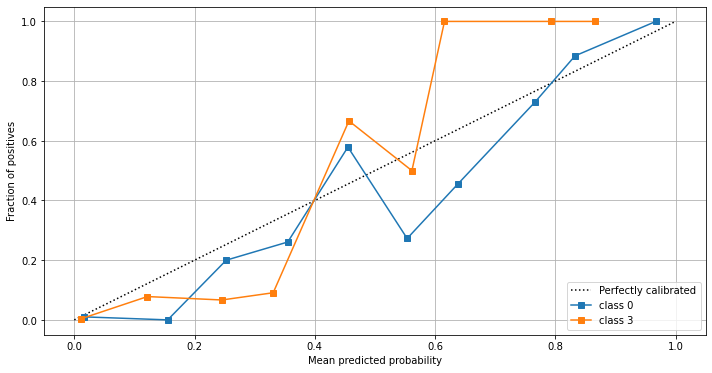

In [10]:
calibration_plot(mlp_regr, test_X, test_Y, probs_given=True, probs=np.clip(mlp_regr.predict(test_X),0,1))

In [9]:
preds = regression_label(mlp_regr, test_X, mlp_regr_thresholds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.55245   0.85870   0.67234        92
           1    0.67143   0.70149   0.68613        67
           2    0.42308   0.55000   0.47826        20
           3    0.75000   0.40000   0.52174        15

   micro avg    0.57895   0.73711   0.64853       194
   macro avg    0.59924   0.62755   0.58962       194
weighted avg    0.59548   0.73711   0.64545       194
 samples avg    0.10608   0.10261   0.09888       194



## Group 3: Time Series Modelling

Old score was 0.72757, new best score 0.73471.

In [13]:
# special data preprocessing for sktime
from sktime.transformations.panel.compose import ColumnConcatenator
PAST_TRACK_LIMIT = 24

def convert_X(dataset_X):
    '''Takes in a (n_samples, n_features) Pandas dataframe and returns it in shape (n_samples, n_features, time_series_length)'''
    processed_samples = 0
    new_dataset = []
    for index, row in dataset_X.iterrows():
        new_row = []

        # obtain time series for each feature        
        for i in range(12): # 10 for baseline_dataset_ts_24, 12 for tsnv
            feature_name = dataset_X.columns[i][:-2]
            feature_series = []
            for j in range(0, PAST_TRACK_LIMIT+6, 6):        
                feature_series.append(row.loc["{0}{1:02d}".format(feature_name, j)]) # access by column name
            feature_series.reverse() # newest data come last
            feature_series = pd.Series(data=feature_series) # correct type for each cell
            new_row.append(feature_series)

        # new_row = pd.Series(data=new_row, index=new_features)
        new_dataset.append(new_row)
        processed_samples += 1

        if processed_samples % 1000 == 0:
            print("Finished concatenating {0}/{1} samples...".format(processed_samples, dataset_X.shape[0]))
            
    # convert types back
    # converted_X = pd.DataFrame(new_dataset, columns=new_features)
    converted_X = np.array(new_dataset)
    print("Completed")
    return converted_X

concat_train_X = convert_X(train_X)
concat_dev_X = convert_X(dev_X)
concat_test_X = convert_X(test_X)
print("Before transform:", concat_test_X.shape)
concat_train_X = ColumnConcatenator().fit_transform(concat_train_X)
concat_dev_X = ColumnConcatenator().fit_transform(concat_dev_X)
concat_test_X = ColumnConcatenator().fit_transform(concat_test_X)
print("After transform:", concat_test_X.shape)
print("Each element is:", concat_test_X.iloc[0].iloc[0].shape)

Finished concatenating 1000/5634 samples...
Finished concatenating 2000/5634 samples...
Finished concatenating 3000/5634 samples...
Finished concatenating 4000/5634 samples...
Finished concatenating 5000/5634 samples...
Completed
Completed
Completed
Before transform: (696, 12, 5)
After transform: (696, 1)
Each element is: (60,)


##### Grid search optimized time series forest classifier

In [32]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tsfs_clf = joblib.load("./models/baseline_model_downsampled_gscv_tsfs_clf_2022-04-06 19-42.skl")
tsfs_clf_thresholds = [0.44000, 0.40000, 0.42000, 0.32000]

Brier score losses: (the smaller the better)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

Class 0, no calibration: 0.038562
Class 1, no calibration: 0.031492
Class 2, no calibration: 0.014568
Class 3, no calibration: 0.012753


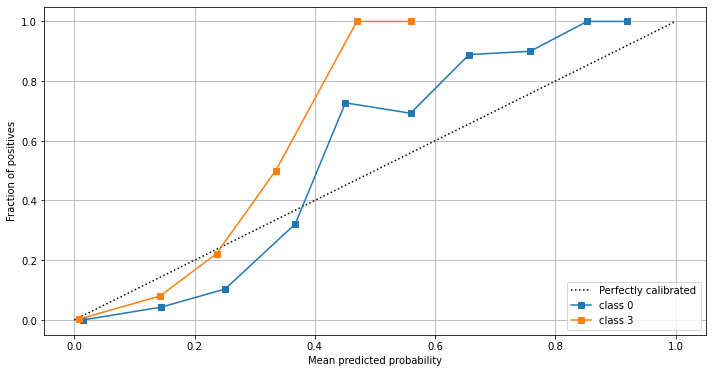

In [34]:
calibration_plot(tsfs_clf, concat_test_X, test_Y)

In [35]:
preds = predictions_with_thresholds(tsfs_clf, tsfs_clf_thresholds, concat_test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.88750   0.77174   0.82558        92
           1    0.83607   0.76119   0.79688        67
           2    0.85714   0.60000   0.70588        20
           3    0.87500   0.46667   0.60870        15

   micro avg    0.86503   0.72680   0.78992       194
   macro avg    0.86393   0.64990   0.73426       194
weighted avg    0.86564   0.72680   0.78656       194
 samples avg    0.10369   0.10153   0.09893       194



##### Grid search optimized time series forest classifier, calibrated

In [36]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tsfs_calibrated_clf = joblib.load("./models/baseline_model_downsampled_calibrated_gscv_tsfs_clf_2022-04-06 19-48.skl")
tsfs_calibrated_clf_thresholds = [0.53057, 0.46525, 0.63891, 0.56468]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.032439
Class 1, no calibration: 0.027855
Class 2, no calibration: 0.012812
Class 3, no calibration: 0.010691


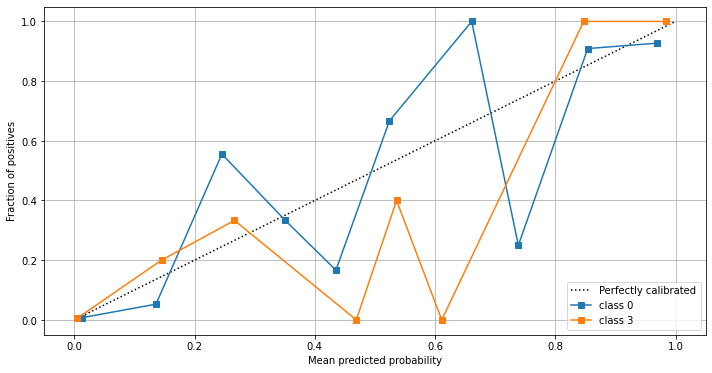

In [37]:
calibration_plot(tsfs_calibrated_clf, concat_test_X, test_Y)

In [38]:
preds = predictions_with_thresholds(tsfs_calibrated_clf, tsfs_calibrated_clf_thresholds, concat_test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.86747   0.78261   0.82286        92
           1    0.82258   0.76119   0.79070        67
           2    0.85714   0.60000   0.70588        20
           3    0.87500   0.46667   0.60870        15

   micro avg    0.85030   0.73196   0.78670       194
   macro avg    0.85555   0.65262   0.73203       194
weighted avg    0.85148   0.73196   0.78313       194
 samples avg    0.10512   0.10201   0.09965       194



##### Grid search optimized time series forest regressor

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tsfs_regr = joblib.load("./models/baseline_model_downsampled_gscv_tsfs_regr_2022-04-16 15-22.skl")
tsfs_regr_thresholds = [0.37000, 0.45333, 0.42000, 0.24667]

Brier score losses: (the smaller the better)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

Class 0, no calibration: 0.039852
Class 1, no calibration: 0.032205
Class 2, no calibration: 0.014461
Class 3, no calibration: 0.013601


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

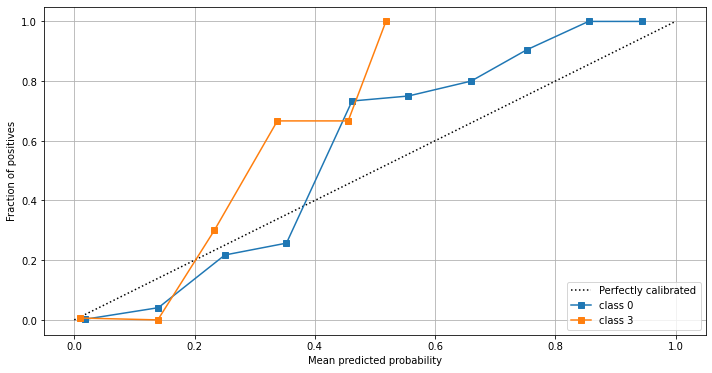

In [15]:
calibration_plot(tsfs_regr, concat_test_X, test_Y)

In [17]:
preds = regression_label(tsfs_regr, concat_test_X, tsfs_regr_thresholds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.80412   0.84783   0.82540        92
           1    0.87273   0.71642   0.78689        67
           2    0.85714   0.60000   0.70588        20
           3    0.64286   0.60000   0.62069        15

   micro avg    0.81667   0.75773   0.78610       194
   macro avg    0.79421   0.69106   0.73471       194
weighted avg    0.82081   0.75773   0.78395       194
 samples avg    0.11039   0.10680   0.10454       194



## Group 4: Linear models - GAM

Old score 0.60176, new score 0.75851 (regardless of regression adjustment method: expit or clip).

In [5]:
import pickle as pk
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_classif #, SelectFromModel
from functools import partial
from pygam import LinearGAM, PoissonGAM

# file = open("./models/baseline_model_downsampled_gam_2022-04-08 20-39.pkl", "rb") 
file = open("./models/baseline_model_downsampled_gam_2022-04-14 18-59.pkl", "rb") 
gam = pk.load(file)
file.close()
# gam_thresholds = [0.62554, 0.59085, 0.58430, 0.58145]
gam_thresholds = [0.51311, 0.36747, 0.34045, 0.32873]

In [8]:
# generate predictions
raw_preds = []
for i in range(4):
    tr_test_X = gam["fs"][i].transform(gam["poly"][i].transform(test_X.iloc[:,:13]))
    # preds = expit(gam["gam"][i].predict(tr_test_X))
    preds = np.clip(gam["gam"][i].predict(tr_test_X),0,1)
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

(696, 4)


Brier score losses: (the smaller the better)
Class 0, no calibration: 0.039477
Class 1, no calibration: 0.031015
Class 2, no calibration: 0.015741
Class 3, no calibration: 0.012809


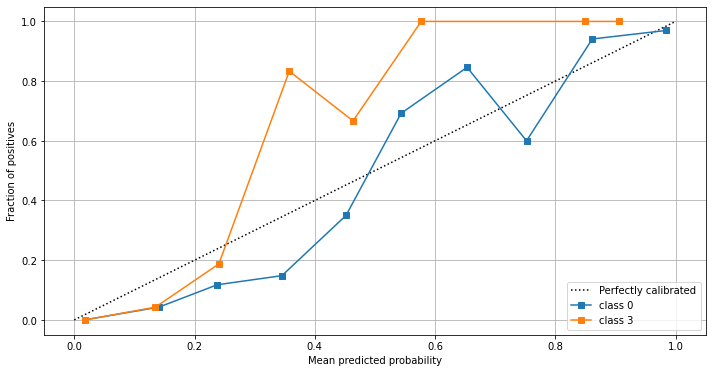

In [9]:
calibration_plot(gam, test_X, test_Y, probs_given=True, probs=raw_preds)

In [10]:
preds = regression_label(gam, test_X, gam_thresholds, probs_given=True, probs=raw_preds)
print(classification_report(test_Y, preds, digits=5, zero_division=0))

              precision    recall  f1-score   support

           0    0.86905   0.79348   0.82955        92
           1    0.77465   0.82090   0.79710        67
           2    0.68421   0.65000   0.66667        20
           3    0.83333   0.66667   0.74074        15

   micro avg    0.81183   0.77835   0.79474       194
   macro avg    0.79031   0.73276   0.75851       194
weighted avg    0.81463   0.77835   0.79468       194
 samples avg    0.10824   0.10896   0.10508       194



## Feature importances
### No polynomials, according to XGBoost

In [8]:
importance = np.stack([list(train_X.columns), xgb_gscv_regr.estimators_[0].feature_importances_], axis=1)
importance = importance[np.argsort(importance[:,1])]
print(np.flip(importance, axis=0)[:50,0])
print(np.flip(importance, axis=0)[:50,:])

['MI_STATUS00' 'MI_STATUS06' 'MI_STATUS12' 'MM18' 'DIST06' 'DIST00' 'MM24'
 'AZM06' 'LI_STATUS00' 'MM00' 'MM06' 'MM12' 'AZM18' 'AZM00' 'LI_STATUS06'
 'SI_STATUS06' 'LI_STATUS18' 'DS_STATUS00' 'DIST18' 'VMAX18' 'DD18' 'DD06'
 'DIR06' 'DD00' 'VMAX06' 'LI_STATUS24' 'AZM12' 'DS_STATUS12' 'DIR12'
 'DD24' 'DIST24' 'VMAX24' 'VMAX00' 'DD12' 'LI_STATUS12' 'DS_STATUS06'
 'DIR00' 'SPEED00' 'VMAX12' 'AZM24' 'SPEED18' 'SPEED06' 'DIST12'
 'SI_STATUS00' 'SI_STATUS12' 'DVMAX12' 'DIR24' 'SPEED12' 'DVMAX00'
 'SPEED24']
[['MI_STATUS00' '0.4406241']
 ['MI_STATUS06' '0.06347204']
 ['MI_STATUS12' '0.034035455']
 ['MM18' '0.030296832']
 ['DIST06' '0.029668018']
 ['DIST00' '0.027934117']
 ['MM24' '0.024266494']
 ['AZM06' '0.020928772']
 ['LI_STATUS00' '0.020441337']
 ['MM00' '0.01924383']
 ['MM06' '0.019084675']
 ['MM12' '0.018205097']
 ['AZM18' '0.016832544']
 ['AZM00' '0.014979237']
 ['LI_STATUS06' '0.012206551']
 ['SI_STATUS06' '0.0092492215']
 ['LI_STATUS18' '0.008963372']
 ['DS_STATUS00' '0.008882022']
 

In [11]:
importance = np.stack([list(train_X.columns), xgb_gscv_regr.estimators_[1].feature_importances_], axis=1)
importance = importance[np.argsort(importance[:,1])]
print(np.flip(importance, axis=0)[:50,0])
print(np.flip(importance, axis=0)[:50,:])

['SI_STATUS24' 'LI_STATUS00' 'MI_STATUS00' 'SI_STATUS00' 'MI_STATUS06'
 'LI_STATUS06' 'DIST00' 'MI_STATUS12' 'MM18' 'DIST06' 'SI_STATUS06' 'MM06'
 'MM00' 'AZM00' 'AZM18' 'AZM06' 'LI_STATUS18' 'MM12' 'DIST18'
 'SI_STATUS12' 'MM24' 'DD24' 'VMAX06' 'DD18' 'DIR00' 'DIR06' 'SPEED18'
 'DD00' 'VMAX18' 'DD06' 'VMAX00' 'DIST24' 'DIR12' 'SPEED00' 'VMAX24'
 'MI_STATUS18' 'VMAX12' 'DIST12' 'DD12' 'AZM24' 'DS_STATUS18' 'SPEED06'
 'AZM12' 'LI_STATUS12' 'DVMAX18' 'DVMAX00' 'DS_STATUS00' 'SPEED24' 'DIR24'
 'SPEED12']
[['SI_STATUS24' '5.0738465e-05']
 ['LI_STATUS00' '0.33597922']
 ['MI_STATUS00' '0.05216328']
 ['SI_STATUS00' '0.05016532']
 ['MI_STATUS06' '0.04802015']
 ['LI_STATUS06' '0.04040972']
 ['DIST00' '0.034623753']
 ['MI_STATUS12' '0.028554616']
 ['MM18' '0.028006021']
 ['DIST06' '0.023615103']
 ['SI_STATUS06' '0.023118114']
 ['MM06' '0.016656764']
 ['MM00' '0.01631593']
 ['AZM00' '0.015159971']
 ['AZM18' '0.014840506']
 ['AZM06' '0.013795599']
 ['LI_STATUS18' '0.013349735']
 ['MM12' '0.0129232

In [12]:
importance = np.stack([list(train_X.columns), xgb_gscv_regr.estimators_[2].feature_importances_], axis=1)
importance = importance[np.argsort(importance[:,1])]
print(np.flip(importance, axis=0)[:50,0])
print(np.flip(importance, axis=0)[:50,:])

['SI_STATUS00' 'MI_STATUS00' 'DS_STATUS00' 'SI_STATUS06' 'DIST06' 'DIST00'
 'MM18' 'MI_STATUS06' 'AZM18' 'AZM06' 'MM12' 'AZM00' 'DS_STATUS06' 'MM00'
 'DIR12' 'DIR06' 'MM06' 'DIST18' 'DD00' 'MI_STATUS12' 'DD18' 'DIST12'
 'SPEED00' 'VMAX00' 'DD12' 'DIR00' 'VMAX06' 'VMAX18' 'DD06' 'DIST24'
 'DD24' 'SPEED12' 'HH06' 'DS_STATUS12' 'MM24' 'DIR24' 'MI_STATUS18'
 'SPEED18' 'DIR18' 'AZM24' 'LI_STATUS06' 'VMAX24' 'VMAX12' 'SPEED24'
 'AZM12' 'SPEED06' 'LI_STATUS00' 'DVMAX00' 'SI_STATUS12' 'DVMAX18']
[['SI_STATUS00' '0.29625386']
 ['MI_STATUS00' '0.052818265']
 ['DS_STATUS00' '0.043744564']
 ['SI_STATUS06' '0.035948377']
 ['DIST06' '0.027189307']
 ['DIST00' '0.026722284']
 ['MM18' '0.024537783']
 ['MI_STATUS06' '0.023517858']
 ['AZM18' '0.021180553']
 ['AZM06' '0.01912121']
 ['MM12' '0.018049803']
 ['AZM00' '0.017425066']
 ['DS_STATUS06' '0.017387882']
 ['MM00' '0.016706582']
 ['DIR12' '0.015373953']
 ['DIR06' '0.015245721']
 ['MM06' '0.014876902']
 ['DIST18' '0.014421912']
 ['DD00' '0.013877679']


In [13]:
importance = np.stack([list(train_X.columns), xgb_gscv_regr.estimators_[3].feature_importances_], axis=1)
importance = importance[np.argsort(importance[:,1])]
print(np.flip(importance, axis=0)[:50,0])
print(np.flip(importance, axis=0)[:50,:])

['LI_STATUS24' 'SI_STATUS18' 'SI_STATUS24' 'DS_STATUS18' 'DS_STATUS00'
 'MI_STATUS00' 'MI_STATUS06' 'AZM00' 'DIST18' 'DD18' 'AZM06' 'DIST00'
 'MM18' 'VMAX06' 'DIR12' 'DD06' 'AZM18' 'DIR06' 'DD12' 'DIR00' 'SPEED18'
 'MM06' 'VMAX18' 'DIST12' 'DIR18' 'VMAX00' 'DD24' 'MM00' 'DIST06' 'DD00'
 'SPEED06' 'DIR24' 'MI_STATUS18' 'SPEED12' 'AZM12' 'DIST24' 'SPEED00'
 'SPEED24' 'MM24' 'VMAX24' 'AZM24' 'MM12' 'VMAX12' 'DS_STATUS06' 'HH12'
 'DVMAX18' 'DVMAX00' 'DVMAX12' 'SI_STATUS00' 'HH00']
[['LI_STATUS24' '9.432432e-05']
 ['SI_STATUS18' '5.3870135e-05']
 ['SI_STATUS24' '3.0982264e-05']
 ['DS_STATUS18' '1.2323409e-05']
 ['DS_STATUS00' '0.30365652']
 ['MI_STATUS00' '0.051049396']
 ['MI_STATUS06' '0.037348952']
 ['AZM00' '0.03251331']
 ['DIST18' '0.02884308']
 ['DD18' '0.028367912']
 ['AZM06' '0.023943052']
 ['DIST00' '0.021756578']
 ['MM18' '0.019630672']
 ['VMAX06' '0.019415058']
 ['DIR12' '0.018790899']
 ['DD06' '0.018320024']
 ['AZM18' '0.017982747']
 ['DIR06' '0.016644929']
 ['DD12' '0.016625427'

### With polynomials, according to MI

In [22]:
names = gam["poly"][0].get_feature_names_out()
mask = gam["fs"][0].get_support()
scores = gam["fs"][0].scores_
importance = np.stack([names[mask], scores[mask]], axis=1)
importance = importance[np.argsort(importance[:,1])]
for item in np.flip(importance, axis=0)[:50,0]:
    print(item, end=',')
print()
print(np.flip(importance, axis=0)[:50,:])

MM00 DIST00^2,DIST00,DIST00^3,DIST00^2,DIST00^2 VMAX00,MM00 DIST00,DIST00^2 SPEED00,DIST00^2 AZM00,MM00^2 DIST00,MI_STATUS00^2 SPEED00,MM00 DD00^2,MI_STATUS00 VMAX00^2,MM00 DD00 MI_STATUS00,MI_STATUS00 DIST00,MI_STATUS00 VMAX00,DIST00 VMAX00,MI_STATUS00 SPEED00 VMAX00,MI_STATUS00^2 DIST00,DIST00^2 DVMAX00,MM00 MI_STATUS00 AZM00,MI_STATUS00 SPEED00,MM00 MI_STATUS00 VMAX00,MI_STATUS00 DIR00,HH00 DIST00^2,MI_STATUS00 DIR00 VMAX00,DD00^2 MI_STATUS00,MM00 DIST00 VMAX00,MI_STATUS00 DIST00 AZM00,MM00^2 MI_STATUS00,MI_STATUS00 SPEED00^2,MI_STATUS00^2 AZM00,MM00 MI_STATUS00 DIST00,DD00 MI_STATUS00 DIST00,DD00 DIST00^2,DD00 MI_STATUS00^2,MI_STATUS00^2,MI_STATUS00 AZM00 SPEED00,MI_STATUS00 AZM00^2,AZM00,DD00 MI_STATUS00,MM00 MI_STATUS00^2,AZM00^3,AZM00^2,DD00 MI_STATUS00 AZM00,MI_STATUS00 AZM00,MI_STATUS00^3,DD00 MI_STATUS00 VMAX00,MI_STATUS00 AZM00 DIR00,MM00 MI_STATUS00,MM00^2 DD00,
[['MM00 DIST00^2' 0.11726569215731253]
 ['DIST00' 0.11434817838089462]
 ['DIST00^3' 0.1141069264744925]
 ['DIST00

In [20]:
names = gam["poly"][1].get_feature_names_out()
mask = gam["fs"][1].get_support()
scores = gam["fs"][1].scores_
importance = np.stack([names[mask], scores[mask]], axis=1)
importance = importance[np.argsort(importance[:,1])]
for item in np.flip(importance, axis=0)[:50,0]:
    print(item, end=',')
print()
print(np.flip(importance, axis=0)[:50,:])

DIST00,DIST00^3,MM00 DIST00^2,DIST00^2,MM00 DIST00,DIST00^2 VMAX00,DIST00^2 AZM00,DIST00^2 SPEED00,MM00^2 DIST00,DD00 DIST00^2,HH00 DIST00^2,AZM00^3,AZM00^2,AZM00,MM00 DD00^2,DIST00 VMAX00,DIST00^2 DIR00,DIST00 DIR00^2,DIST00 SPEED00,DIST00 AZM00,MM00 DIST00 VMAX00,MM00 DIST00 SPEED00,DIST00^2 DVMAX00,MM00^2 VMAX00,MM00^2 DD00,MM00 DIST00 AZM00,MM00 VMAX00^2,LI_STATUS00^2 SPEED00,HH00 DIST00,DIST00 DVMAX00,MM00^3,MM00 AZM00^2,MM00 SPEED00^2,MM00 LI_STATUS00 VMAX00,MM00^2 SPEED00,MM00 LI_STATUS00 DIST00,LI_STATUS00 DIST00 DIR00,DIST00 AZM00 DIR00,MM00 HH00 DIST00,MM00,DD00 LI_STATUS00 VMAX00,LI_STATUS00^3,DD00 LI_STATUS00^2,AZM00^2 DIR00,MM00^2 LI_STATUS00,MM00 DD00,LI_STATUS00 SPEED00 VMAX00,DD00 DIST00,LI_STATUS00 DIR00 VMAX00,LI_STATUS00^2,
[['DIST00' 0.09142916200391338]
 ['DIST00^3' 0.09129264973285856]
 ['MM00 DIST00^2' 0.09126350618923085]
 ['DIST00^2' 0.09125094225585162]
 ['MM00 DIST00' 0.08300612080069114]
 ['DIST00^2 VMAX00' 0.07725210668201177]
 ['DIST00^2 AZM00' 0.073629919

In [21]:
names = gam["poly"][2].get_feature_names_out()
mask = gam["fs"][2].get_support()
scores = gam["fs"][2].scores_
importance = np.stack([names[mask], scores[mask]], axis=1)
importance = importance[np.argsort(importance[:,1])]
for item in np.flip(importance, axis=0)[:50,0]:
    print(item, end=',')
print()
print(np.flip(importance, axis=0)[:50,:])

DIST00,DIST00^2,DIST00^3,MM00 DIST00^2,DIST00^2 SPEED00,DIST00^2 VMAX00,MM00 DIST00,DIST00^2 AZM00,MM00^2 DIST00,HH00 DIST00^2,DD00 DIST00^2,MM00 DIST00 AZM00,DIST00^2 DVMAX00,MM00^2 DIR00,DIST00 AZM00,MM00 DIST00 VMAX00,DIST00 VMAX00,MM00 DD00^2,HH00 DIST00,DIST00 DVMAX00,DIST00^2 DIR00,AZM00 DIR00,DIST00 DIR00^2,MM00 DIST00 SPEED00,MM00 DIR00,MM00 HH00 DIST00,MM00^2 DD00,MM00^2,MM00,MM00^3,AZM00^2 DIR00,MM00 DD00,MM00 SPEED00^2,MM00 DIST00 DVMAX00,AZM00^3,DIST00 SPEED00,AZM00^2,AZM00,SI_STATUS00 DIR00^2,SI_STATUS00^2 VMAX00,DIST00 AZM00 VMAX00,DIST00 VMAX00 DVMAX00,HH00 DIST00 AZM00,SI_STATUS00 DIST00,SI_STATUS00 SPEED00 VMAX00,MM00^2 SPEED00,MM00^2 VMAX00,SI_STATUS00 DIST00^2,MM00 DD00 DIST00,SI_STATUS00 DIR00,
[['DIST00' 0.04359504313815998]
 ['DIST00^2' 0.04352250309358241]
 ['DIST00^3' 0.0433423592388793]
 ['MM00 DIST00^2' 0.04208049160851646]
 ['DIST00^2 SPEED00' 0.037485765774232904]
 ['DIST00^2 VMAX00' 0.03731295253429523]
 ['MM00 DIST00' 0.0371615542824717]
 ['DIST00^2 AZM00'

In [23]:
names = gam["poly"][3].get_feature_names_out()
mask = gam["fs"][3].get_support()
scores = gam["fs"][3].scores_
importance = np.stack([names[mask], scores[mask]], axis=1)
importance = importance[np.argsort(importance[:,1])]
for item in np.flip(importance, axis=0)[:50,0]:
    print(item, end=',')
print()
print(np.flip(importance, axis=0)[:50,:])

MM00 DIST00,MM00 DIST00^2,DIST00^2,DIST00,DIST00^3,DIST00^2 VMAX00,MM00^2 DIST00,DIST00 VMAX00,MM00 DD00^2,DIST00^2 AZM00,MM00 DIST00 VMAX00,DIST00^2 SPEED00,MM00^2 DIR00,MM00 VMAX00^2,MM00^2 VMAX00,HH00 DIST00^2,MM00^3,MM00^2,MM00 DIST00 AZM00,DD00 DIST00^2,MM00^2 DD00,DIST00 AZM00,MM00 SPEED00^2,MM00 DIR00,HH00 DIST00 VMAX00,MM00 HH00 DIST00,MM00 DIST00 SPEED00,MM00^2 SPEED00,MM00 MI_STATUS00 AZM00,DIST00^2 DIR00,DIST00 DVMAX00,MM00^2 HH00,MM00,MM00 DIST00 DIR00,MM00 DD00,HH00 DIST00,DD00^2 DS_STATUS00,DIST00 SPEED00,MM00 DIST00 DVMAX00,DIST00 SPEED00 VMAX00,MM00 DS_STATUS00^2,DIST00 AZM00 VMAX00,MM00 SPEED00,DIST00^2 DVMAX00,DS_STATUS00^2 VMAX00,DS_STATUS00^3,DIST00 VMAX00 DVMAX00,MM00 MI_STATUS00 SPEED00,MM00 DS_STATUS00 VMAX00,DS_STATUS00 AZM00 SPEED00,
[['MM00 DIST00' 0.028731790775937016]
 ['MM00 DIST00^2' 0.027107437605569662]
 ['DIST00^2' 0.0270004542534521]
 ['DIST00' 0.02691592236309759]
 ['DIST00^3' 0.026887930805683302]
 ['DIST00^2 VMAX00' 0.026577833386951633]
 ['MM00^2 D